In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Derivation of normal modes

We assume 2 carts connected to eachother and 2 posts by 3 springs, where the outside springs (cart-to-post) have spring constant $k_2 = k_3 = k$, and the inside spring (cart-to-cart) has $k_1 = k'$. The odd numbering is because we labeled them as we found them (left to right laid out on the desk), finding $k_1 = 17.63$, 

## FFT

First, we'll import our csv files. Each contains a trial of two columns, where column 0 is time and column 1 is position.

In [146]:
antisym1 = pd.read_csv('data/raw data/antisym1.csv', sep=',', header=0)
antisym2 = pd.read_csv('data/raw data/antisym2.csv', sep=',', header=0)
antisym3 = pd.read_csv('data/raw data/antisym3.csv', sep=',', header=0)

sym1 = pd.read_csv('data/raw data/sym1.csv', sep=',', header=0)
sym2 = pd.read_csv('data/raw data/sym2.csv', sep=',', header=0)
sym3 = pd.read_csv('data/raw data/sym3.csv', sep=',', header=0)

mixed1 = pd.read_csv('data/raw data/mixed1.csv', sep=',', header=0)
mixed2 = pd.read_csv('data/raw data/mixed2.csv', sep=',', header=0)
mixed3 = pd.read_csv('data/raw data/mixed3.csv', sep=',', header=0)



Before performing our FFT, we need to clean up the data. There is a flat region before we release the carts from equilibrium, but after pressing "collect data" (or whatever the button is called). We need to remove this region, which we do by finding the index in the dataframe when the position
first changes, and getting rid of all the indices before that.

We also need our data to be displacements rather than positions. Right now each position includes the distance from the sensor to the cart, but we really want the displacement from equilibrium. To make that happen, we need to subtract off the mean from each position, which makes the average zero.

In [154]:
def clean_data(dataframe):
    first_value = dataframe['position'][0]  # First position
    current_index = 0

    while(dataframe['position'][current_index] == first_value):
        current_index += 1

    # Remove everything before the index where position changes
    clean_dataframe = dataframe.drop(range(0,current_index-1))
    clean_dataframe = clean_dataframe.reset_index(drop=True)  # Dropping those indices doesn't reset indices, so the first entry needs to be manually reset back to index 0
    
    # Shift positions so the average is zero
    average_position = np.mean(clean_dataframe['position'])
    clean_dataframe['position'] = clean_dataframe['position'] - average_position
    
    return clean_dataframe

In [155]:
antisym1_clean = clean_data(antisym1)
antisym2_clean = clean_data(antisym2)
antisym3_clean = clean_data(antisym3)

sym1_clean = clean_data(sym1)
sym2_clean = clean_data(sym2)
sym3_clean = clean_data(sym3)

mixed1_clean = clean_data(mixed1)
mixed2_clean = clean_data(mixed1)
mixed3_clean = clean_data(mixed1)

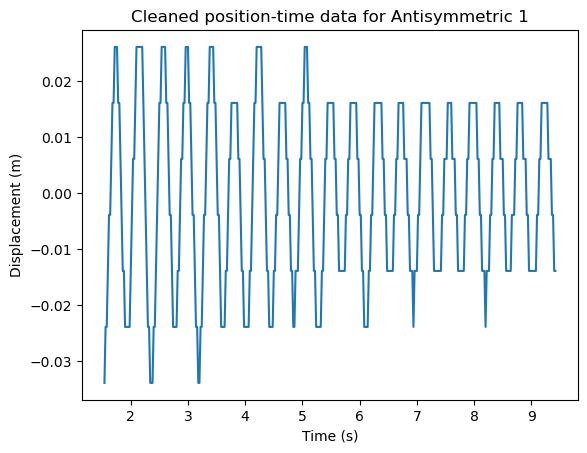

In [161]:
plt.plot(antisym1_clean['time'], antisym1_clean['position'])
plt.title("Cleaned position-time data for Antisymmetric 1")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.show()

We now perform the Fast Fourier transform on our data. This is done with np.fft.rfft(), the "real fast fourier transform." A typical Fourier transform is defined on the complex numbers, but since our input is only real numbers (time and position values), the full Fourier transform would be symmetric. Using rfft allows us to only do half of the computations.

In [162]:
def fft_series(clean_dataframe):
    dt = clean_dataframe['time'][1] - clean_dataframe['time'][0]
    
    frame_fft = np.fft.rfft(clean_dataframe['position'])
    frame_freq = np.fft.rfftfreq(len(clean_dataframe['time']), d=dt)
    frame_amplitude = np.abs(frame_fft)

    # Return 2d array where column 0 is frequencies and column 1 is amplitudes
    fft_array = np.array([frame_freq, frame_amplitude])
    return fft_array


In [114]:
antisym1_fft = fft_series(antisym1_clean)
antisym2_fft = fft_series(antisym2_clean)
antisym3_fft = fft_series(antisym3_clean)

sym1_fft = fft_series(sym1_clean)
sym2_fft = fft_series(sym2_clean)
sym3_fft = fft_series(sym3_clean)

mixed1_fft = fft_series(mixed1_clean)
mixed2_fft = fft_series(mixed2_clean)
mixed3_fft = fft_series(mixed3_clean)

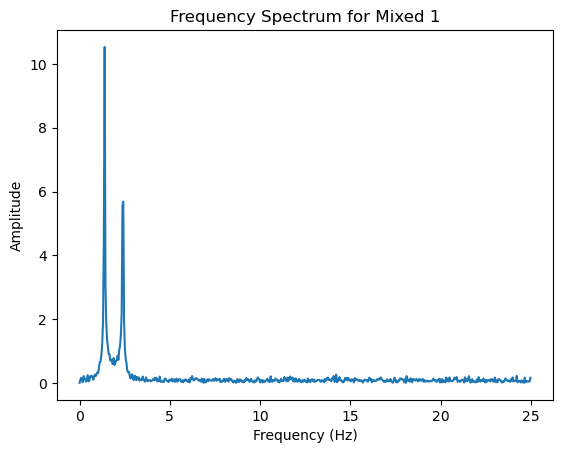

In [167]:
plt.plot(mixed1_fft[0], mixed1_fft[1])
plt.title("Frequency Spectrum for Mixed 1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

With the FFT performed, we want to do different things for the normal modes (antisymmetric and symmetric) versus the mixed modes. For the normal modes, the goal is to find
the frequency that occurs with the greatest amplitude. This should be one fairly obvious peak in the frequency spectrum. For the mixed modes, we know the true frequency is a linear combination of the two normal modes; we want to find the coffiecients $A$ and $B$ of $f = Af_{\text{symmetric}} + Bf_{\text{antisymmetric}}$,
where $\sqrt{A^2 + B^2} = 1$. We see the graph has two large peaks.

In [127]:
def dominant_frequency(fft_data):
    return fft_data[0][np.argmax(fft_data[1])]

In [128]:
antisym1_dom_freq = dominant_frequency(antisym1_fft)
antisym2_dom_freq = dominant_frequency(antisym2_fft)
antisym3_dom_freq = dominant_frequency(antisym3_fft)

sym1_dom_freq = dominant_frequency(sym1_fft)
sym2_dom_freq = dominant_frequency(sym2_fft)
sym3_dom_freq = dominant_frequency(sym3_fft)

In [170]:
print(antisym3_dom_freq)

2.4282560706402014


In [129]:
antisym_avg_dom_freq = (antisym1_dom_freq + antisym2_dom_freq + antisym3_dom_freq) / 3
sym_avg_dom_freq = (sym1_dom_freq + sym2_dom_freq + sym3_dom_freq) / 3


In [165]:
print(f"Average of antisymmetric dominant frequencies: {antisym_avg_dom_freq}")
print(f"Average of symmetric dominant frequencies: {sym_avg_dom_freq}")

Average of antisymmetric dominant frequencies: 2.42725765667562
Average of symmetric dominant frequencies: 1.3668466696367148
